## dask <code>compute()</code> Deferred Computing

We're going to build a somewhat interesting workload and then run it a couple of different ways.  Let's start by loading the NYC flight data.

This exercise will reinforce dask dataframe programming concepts by building a set of analyses. We will then use these type of `groupby` and aggregate queries to look at execution properties.

Code that you need to write is indicated with #TODO. I've left the output of the reference implementation in the cells so that you can refer to it for correctness.  You can refer to the read-only shared version for this output.

Read in the NYC Flights data from Google cloud storage and then print the dataframe metadata.

In [1]:
import dask.dataframe as dd

df = dd.read_csv("../data/nycflight/*.csv",
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Let's build a set of queries around the performance of particular planes, identified by tail number.  The pattern will be to <code>groupby('TailNum') and then compute statistics.

__Query__: What is the average departure delay 'DepDelay' for each plane?

In [2]:
df_delay = df.groupby('TailNum')['DepDelay'].mean().compute()

Interesting, some planes were early, lets plot a histrogram of the distribution with 1000 bins.

<Axes: >

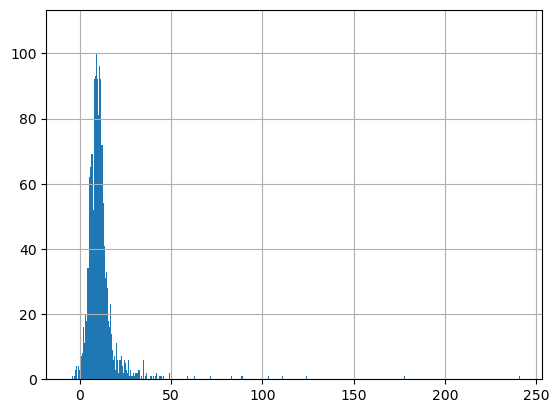

In [3]:
%matplotlib inline
df_delay.hist(bins=1000)

OK, we have very few chronically bad planes.  Let's find those that are 30 (or more) minutes late on average.

In [4]:
import numpy as np
lateplanes = df_delay[df_delay >= 30].index.tolist()
print(np.sort(lateplanes))

['N101UW' 'N102UW' 'N104UW' 'N106UW' 'N128AW' 'N133JC' 'N133TW' 'N134TW'
 'N14249' 'N144JC' 'N147US' 'N151AW' 'N151UA' 'N152UA' 'N153US' 'N154AA'
 'N154AW' 'N155US' 'N156AW' 'N158AW' 'N161US' 'N168AW' 'N169AW' 'N17010'
 'N17011' 'N1738D' 'N1739D' 'N174AW' 'N174GM' 'N174UA' 'N175UA' 'N17789'
 'N1854U' 'N195UA' 'N199UA' 'N224DA' 'N224NW' 'N225NW' 'N235NW' 'N303TW'
 'N304AW' 'N305AW' 'N305TW' 'N307TW' 'N322AW' 'N328AW' 'N33021' 'N3310L'
 'N331AW' 'N375DA' 'N376DL' 'N379DL' 'N382DA' 'N53110' 'N53116' 'N534TW'
 'N6700' 'N701UW' 'N706UW' 'N708UW' 'N713DA' 'N713UW' 'N716DA' 'N719DA'
 'N724DA' 'N727UW' 'N733DS' 'N735D' 'N737D' 'N760DH' 'N78019' 'N787DL'
 'N789DL' 'N802DE' 'N805DE' 'N817AA' 'N8911E' 'N93104' 'N93107' 'N93108'
 'N93109' 'N93119' 'N96S' 'N971Z' 'N976UA' 'N993UA' 'NEIDLA' 'UNKNOW']


OK, this is a hard query.
Build a dataframe that is a subset all the data associated with the late planes.  There are many ways to solve this problem. I would recommend looking at the `isin()` function in dask.

In [5]:
df_late = df[df['TailNum'].isin(lateplanes)]
df_late

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Double check that the planes indexes match.

In [6]:
import numpy as np
latelist = df_late['TailNum'].unique().compute()
print(np.sort(latelist))

['N101UW' 'N102UW' 'N104UW' 'N106UW' 'N128AW' 'N133JC' 'N133TW' 'N134TW'
 'N14249' 'N144JC' 'N147US' 'N151AW' 'N151UA' 'N152UA' 'N153US' 'N154AA'
 'N154AW' 'N155US' 'N156AW' 'N158AW' 'N161US' 'N168AW' 'N169AW' 'N17010'
 'N17011' 'N1738D' 'N1739D' 'N174AW' 'N174GM' 'N174UA' 'N175UA' 'N17789'
 'N1854U' 'N195UA' 'N199UA' 'N224DA' 'N224NW' 'N225NW' 'N235NW' 'N303TW'
 'N304AW' 'N305AW' 'N305TW' 'N307TW' 'N322AW' 'N328AW' 'N33021' 'N3310L'
 'N331AW' 'N375DA' 'N376DL' 'N379DL' 'N382DA' 'N53110' 'N53116' 'N534TW'
 'N6700' 'N701UW' 'N706UW' 'N708UW' 'N713DA' 'N713UW' 'N716DA' 'N719DA'
 'N724DA' 'N727UW' 'N733DS' 'N735D' 'N737D' 'N760DH' 'N78019' 'N787DL'
 'N789DL' 'N802DE' 'N805DE' 'N817AA' 'N8911E' 'N93104' 'N93107' 'N93108'
 'N93109' 'N93119' 'N96S' 'N971Z' 'N976UA' 'N993UA' 'NEIDLA' 'UNKNOW']


In [7]:
assert (np.sort(lateplanes) == np.sort(latelist)).all()

Now, let's get a sense of what airports these planes fly out of.  For the planes in the late_list, let's find out the total delay at these airports, the average delay by airport and the total number of flights at each airport.

In [8]:
#TODO total DepDelay for planes by Origin airport
total_delay_by_origin = df_late.groupby('Origin')['DepDelay'].sum().compute()
print(total_delay_by_origin)

Origin
EWR    16982.0
JFK    61684.0
LGA    27789.0
Name: DepDelay, dtype: float64


In [9]:
#TODO average DepDelay for planes by Origin airport
avg_delay_by_origin = df_late.groupby('Origin')['DepDelay'].mean().compute()
print(avg_delay_by_origin)

Origin
EWR    42.992405
JFK    41.763033
LGA    36.042802
Name: DepDelay, dtype: float64


In [10]:
#TODO number of late flights by Origin airport
total_late_flights_by_origin = df_late[df_late['DepDelay']>0].groupby('Origin')['TailNum'].count().compute()
print(total_late_flights_by_origin)


Origin
EWR     270
JFK    1208
LGA     601
Name: TailNum, dtype: int64


I don't know that these statistics all make sense, but that's to debug.

## Deferred computing

We are going to show the value of deferred computation by timing the following
queries in two different ways:

```python
df1 = df.groupby(['Origin','TailNum']).DepDelay.mean()
df2 = df.groupby(['TailNum','Origin']).DepDelay.mean()
df3 = df.groupby(['Origin','TailNum']).DepDelay.max()
df4 = df.groupby(['TailNum','Origin']).DepDelay.max()
```

 1. In one cell, add these lines and then call `compute()` on every step.
 2. In the next cell, add the lines and only call compute at the end.

 First reload the data:

In [11]:
import dask.dataframe as dd
df = dd.read_csv("../data/nycflight/*.csv",
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

Run the workload calling `compute()` on every line.

In [12]:
%%time
df1 = df.groupby(['Origin','TailNum']).DepDelay.mean().compute()
df2 = df.groupby(['TailNum','Origin']).DepDelay.mean().compute()
df3 = df.groupby(['Origin','TailNum']).DepDelay.max().compute()
df4 = df.groupby(['TailNum','Origin']).DepDelay.max().compute()

CPU times: user 11.8 s, sys: 926 ms, total: 12.7 s
Wall time: 7.1 s


Load the data again to make sure that intermediate results are not cached and run the entire workload calling `compute()` just once.

In [13]:
import dask.dataframe as dd
df = dd.read_csv("../data/nycflight/*.csv",
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [14]:
from dask import compute

In [16]:
%%time

df1 = df.groupby(['Origin','TailNum']).DepDelay.mean()
df2 = df.groupby(['TailNum','Origin']).DepDelay.mean()
df3 = df.groupby(['Origin','TailNum']).DepDelay.max()
df4 = df.groupby(['TailNum','Origin']).DepDelay.max()
compute(df1, df2, df3, df4)

CPU times: user 3.63 s, sys: 280 ms, total: 3.91 s
Wall time: 2.15 s


(Origin  TailNum
 EWR     EI-BWD      9.355140
         EI-CIW     16.283019
         N050AA      8.309677
         N051AA      5.949275
         N052AA     21.845070
                      ...    
 LGA     N993UA     55.000000
         N994UA     -3.250000
         N995UA     14.600000
         N996UA      9.333333
         N998UA      1.750000
 Name: DepDelay, Length: 8861, dtype: float64,
 TailNum  Origin
 EI-BWD   EWR        9.355140
          JFK       11.575758
          LGA       11.626866
 EI-CAL   JFK       23.846154
 EI-CAM   JFK       26.611511
                      ...    
 N993UA   LGA       55.000000
 N994UA   LGA       -3.250000
 N995UA   LGA       14.600000
 N996UA   LGA        9.333333
 N998UA   LGA        1.750000
 Name: DepDelay, Length: 8861, dtype: float64,
 Origin  TailNum
 EWR     EI-BWD     177.0
         EI-CIW     331.0
         N050AA     248.0
         N051AA     140.0
         N052AA     996.0
                    ...  
 LGA     N993UA     227.0
         N994



### Outcomes
* Wrestled with dataframes syntax and concepts.  Good for you.
* Witnessed the benefit of deferred computation.

### Questions

1. On computational reuse in execution graphs:
    1. How much faster is it to defer the computation to the end versus calling `compute()` on every line?  
      
        **Answer**: 
            - Time difference: `12.7s - 4.04s = 9.3s`  
            - Speedup: `12.7/4.04 = 3.14`

    2. What computations are shared in the workflow?  Be specific, i.e. identify the code.  
      
        **Answer**: Specifically, these are the shared computations:

        1. `df.groupby(['Origin','TailNum'])`: This operation is performed twice, once for calculating the mean (`df1`) and once for calculating the max (`df3`).

        2. `df.groupby(['TailNum','Origin'])`: This operation is also performed twice, once for calculating the mean (`df2`) and once for calculating the max (`df4`).

        3. `DepDelay.mean()`: This operation is performed twice, once on the groupby object with `['Origin','TailNum']` and once on the groupby object with `['TailNum','Origin']`.

        4. `DepDelay.max()`: This operation is also performed twice, once on the groupby object with `['Origin','TailNum']` and once on the groupby object with `['TailNum','Origin']`.

        Dask's computation model allows it to recognize these shared computations and optimize them. 

    3. Explain the speedup realized in 1(a). Why is it not faster? Why is it not slower?  
      
        **Answer**: When the `compute()` function is called once at the end, Dask uses lazy evaluation, which means it doesn't actually perform the computations when they're defined, but instead builds a task graph of what needs to be done. When `compute()` is called, Dask executes the entire task graph at once. This allows Dask to optimize the computations, this is why that piece of code is faster than calling `compute()` after each operation, where Dask executes each operation separately, without being able to optimize across operations. 

        However, calling `compute()` at the end is not faster by a factor of 4 (which might be expected since there are 4 `compute()` calls in the other piece of code) because the time taken by a `compute()` call depends on the complexity of the task graph. In the slower code, each `compute()` call has a simpler task graph than the single `compute()` call in the faster code. Therefore, each `compute()` call in the slower code is faster than the `compute()` call in the faster code, but the total time for calling `compute()` 4 times is still longer because the same computations are performed multiple times.

